In [1]:
from google.colab import files
uploaded = files.upload()

Saving TaxiDataCleaned.csv to TaxiDataCleaned.csv


In [2]:
import pandas as pd
import io
import datetime

# read in clean data file
df = pd.read_csv(io.StringIO(uploaded['TaxiDataCleaned.csv'].decode('utf-8')))

# convert to datetime type
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')

# ANOVA Testing

In [ ]:
!pip install pingouin

In [4]:
# libraries requried
import seaborn as sns
from scipy.stats import shapiro, levene
import pingouin as pg
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

In [5]:
#************************** ADDING COLUMNS FOR ANALYSIS **************************

# add new column for the year
df['year'] = df['tpep_pickup_datetime'].dt.year

# helper function to label passenger count as single or multiple
def label_passengers(row):
  if row['passenger_count'] == 1:
    return 'Single'
  if row['passenger_count'] > 1:
    return 'Multiple'

# add new column for single (1) or multiple (2+) passengers
df['passenger_multiple'] = df.apply(label_passengers, axis=1)

# list of all possible years
all_years = df['tpep_pickup_datetime'].dt.year.unique()
all_years.sort()

# list of all possible seasons
all_seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# list of all possible passenger_multiple values
all_passengers = ['Single', 'Multiple']

In [ ]:
df

In [6]:
#************************** ENOUGH SAMPLES EXIST IN EACH GROUP? **************************

# sample size in each year
for year in all_years:
  print(f"Number of samples for {year}: {len(df.loc[df['year'] == year])}")
print('\n')

# sample size in each season
for season in all_seasons:
  print(f"Number of samples for {season}: {len(df.loc[df['season'] == season])}")
print('\n')

# sample size in each passenger group (single vs multiple)
print(f"Number of samples for single passenger: {len(df.loc[df['passenger_multiple'] == 'Single'])}")
print(f"Number of samples for multiple passengers: {len(df.loc[df['passenger_multiple'] == 'Multiple'])}")
print('\n')

Number of samples for 2009: 12000
Number of samples for 2011: 12000
Number of samples for 2019: 11940
Number of samples for 2020: 11145
Number of samples for 2023: 11578


Number of samples for Winter: 14801
Number of samples for Spring: 14625
Number of samples for Summer: 14631
Number of samples for Fall: 14606


Number of samples for single passenger: 41843
Number of samples for multiple passengers: 16009




Enough samples exist in each group for sufficient bootstrapping.

In [7]:
#************************** BOOTSTRAPPING SAMPLES **************************

# perform bootstrap sampling to invoke central limit theorm
# (assumes normal distribution of sample means of n>=30)
# ANOVA needs normal assumption of data

# each bootstrap sample will have a mean of 50 instances in given category
# 100 boot strap samples in each category

# takes a list of all possible attribute values (categorical) and the attribute name (string)
# returns a dataframe of all bootstrapped samples for that particular attribute
def bootstrap(att_values: list, att_name: str):
  np.random.seed(1) # for reproduceability
  boot = []
  for value in att_values:
    for i in range(100):
      # get 50 samples (with replacement) from the same year
      boot_samp = df[df[att_name] == value].sample(n=50, replace = True)
      boot_samp = boot_samp[['tip_percentage', 'trip_distance']]
      # get mean of 50 samples to create a bootstrap sample
      boot_samp = boot_samp.mean().to_frame().transpose()
      boot_samp[att_name] = value
      # add bootstrap sample to new dataframe
      boot.append(boot_samp)
  return pd.concat(boot, ignore_index=True) # list of dfs to single df

boot_year = bootstrap(all_years, 'year')
boot_season = bootstrap(all_seasons, 'season')
boot_passenger = bootstrap(all_passengers, 'passenger_multiple')

In [8]:
#************************** WHY BOOTSTRAP? **************************

# Without bootstrapping, normality and equal variance assumptions for ANOVA are not met
# Below is proof of the failure to meet these assumption with tip_percentage~year as the example

for year in all_years:
    residuals = df.loc[df['year'] == year, 'tip_percentage']
    stat, p = shapiro(residuals)
    if p <= 0.05:
      print(f"Shapiro-Wilk test for {year}: p-value = {p} - NOT NORMAL DISTRIBUTION")
    else:
      print(f"Shapiro-Wilk test for {year}: p-value = {p} - NORMAL DISTRIBUTION")
print('\n')

# check equal variance
stat, p = levene(df.loc[df['year'] == 2009, 'tip_percentage'],
                 df.loc[df['year'] == 2011, 'tip_percentage'],
                 df.loc[df['year'] == 2019, 'tip_percentage'],
                 df.loc[df['year'] == 2020, 'tip_percentage'],
                 df.loc[df['year'] == 2023, 'tip_percentage'])
if p <= 0.05:
  print(f"Levene's test: p-value = {p} - NOT EQUAL VARIANCE")
else:
  print(f"Levene's test: p-value = {p} - EQUAL VARIANCE")

Shapiro-Wilk test for 2009: p-value = 0.0 - NOT NORMAL DISTRIBUTION
Shapiro-Wilk test for 2011: p-value = 0.0 - NOT NORMAL DISTRIBUTION
Shapiro-Wilk test for 2019: p-value = 0.0 - NOT NORMAL DISTRIBUTION
Shapiro-Wilk test for 2020: p-value = 0.0 - NOT NORMAL DISTRIBUTION
Shapiro-Wilk test for 2023: p-value = 0.0 - NOT NORMAL DISTRIBUTION


Levene's test: p-value = 1.7455092808250402e-59 - NOT EQUAL VARIANCE


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [13]:
#************************** HELPER FUNCTIONS FOR ANOVA **************************

# used specifically for levene's test and one-way anova to reduce repetitive code
# takes in attribute name (string), returns list needed for levene and anova argument
def year_input(boot_year, attribute):
  input = [boot_year.loc[boot_year['year'] == 2009, attribute],
           boot_year.loc[boot_year['year'] == 2011, attribute],
           boot_year.loc[boot_year['year'] == 2019, attribute],
           boot_year.loc[boot_year['year'] == 2020, attribute],
           boot_year.loc[boot_year['year'] == 2023, attribute]]
  return input

def season_input(boot_season, attribute):
  input = [boot_season.loc[boot_season['season'] == 'Winter', attribute],
           boot_season.loc[boot_season['season'] == 'Spring', attribute],
           boot_season.loc[boot_season['season'] == 'Summer', attribute],
           boot_season.loc[boot_season['season'] == 'Fall', attribute]]
  return input

def passenger_input(boot_passenger, attribute):
  input = [boot_passenger.loc[boot_passenger['passenger_multiple'] == 'Single', attribute],
           boot_passenger.loc[boot_passenger['passenger_multiple'] == 'Multiple', attribute]]
  return input

# takes in list of all possible attribute values of the categorical variable,
# boot_att a dataframe of one of the bootstraps
# categ_att, categorical attribute to group by (string)
# attribute, numerical attribute of interest (string)
def anova_prep(att_values: list, boot_att: pd.DataFrame, categ_att: str, attribute: str):

  #-----Preliminary Look at Difference-----

  # determine difference in tip_percentage across all years
  for val in att_values:
    print(f"Average {attribute} for {val}: {boot_att.loc[boot_att[categ_att] == val, attribute].mean()}")
  print('\n')

  plt.figure()
  # create grouped boxplot to visualize distribution
  title_name = 'Bootstrapped Distrubution of ' + attribute + ' Grouped by ' + categ_att
  sns.boxplot(x = boot_att[categ_att],
              y = boot_att[attribute])
  plt.title(title_name)

  #-----Check Assumptions of ANOVA-----

  # check normality
  for val in att_values:
      residuals = boot_att.loc[boot_att[categ_att] == val, attribute]
      stat, p = shapiro(residuals)
      if p <= 0.05:
        print(f"Shapiro-Wilk test for {val}: p-value = {p} - NOT NORMAL DISTRIBUTION")
      else:
        print(f"Shapiro-Wilk test for {val}: p-value = {p} - NORMAL DISTRIBUTION")
  print('\n')

  # check equal variance
  if categ_att == 'year':
    stat, p = levene(*year_input(boot_att, attribute))
  elif categ_att == 'season':
    stat, p = levene(*season_input(boot_att, attribute))
  elif categ_att == 'passenger_multiple':
    stat, p = levene(*passenger_input(boot_att, attribute))
  else:
    print('attribute does not exist')
  if p <= 0.05:
    print(f"Levene's test: p-value = {p} - NOT EQUAL VARIANCE")
  else:
    print(f"Levene's test: p-value = {p} - EQUAL VARIANCE")
  return

def anova(boot_att: pd.DataFrame, categ_att: str, attribute: str):

  #-----Perform One-Way ANOVA-----

  if categ_att == 'year':
    anova = f_oneway(*year_input(boot_att, attribute))
  elif categ_att == 'season':
    anova = f_oneway(*season_input(boot_att, attribute))
  elif categ_att == 'passenger_multiple':
    anova = f_oneway(*passenger_input(boot_att, attribute))
  else:
    print('attribute does not exist')
  print(f"The p-value for this ANOVA is: {anova.pvalue}")

  #-----Perform Tukey's Test-----

  if anova.pvalue < 0.05:
    print("REJECT null hypothesis \n")
    print("Post hoc testing: Tukey")
    tukey = pairwise_tukeyhsd(endog=boot_att[attribute],
                              groups=boot_att[categ_att],
                              alpha=0.05)
    print(tukey)
  else:
    pass

  return

-----Comparing mean tip percentage between different years-----
Average tip_percentage for 2009: 6.226487618425438
Average tip_percentage for 2011: 9.047961677603874
Average tip_percentage for 2019: 18.030995672432045
Average tip_percentage for 2020: 18.300698842611485
Average tip_percentage for 2023: 20.019517636248693


Shapiro-Wilk test for 2009: p-value = 1.861941372645625e-18 - NOT NORMAL DISTRIBUTION
Shapiro-Wilk test for 2011: p-value = 0.07309791445732117 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2019: p-value = 0.7043770551681519 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2020: p-value = 0.8271341919898987 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2023: p-value = 0.8239449858665466 - NORMAL DISTRIBUTION


Levene's test: p-value = 0.5728249821491019 - EQUAL VARIANCE


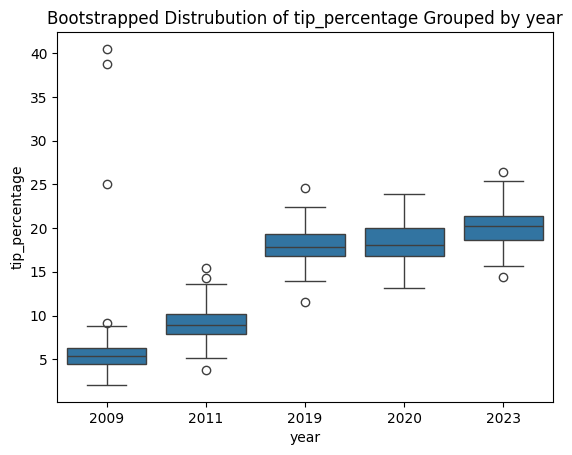

In [14]:
#************************** PERFORMING ANOVA **************************

print(f"-----Comparing mean tip percentage between different years-----")
anova_prep(all_years, boot_year, 'year','tip_percentage')

In [ ]:
anova(boot_year,'year', 'tip_percentage')

The p-value for this ANOVA is: 3.4926899105436916e-157
REJECT null hypothesis 

Post hoc testing: Tukey
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  2009   2011   2.8215    0.0  1.6413  4.0017   True
  2009   2019  11.8045    0.0 10.6243 12.9847   True
  2009   2020  12.0742    0.0  10.894 13.2544   True
  2009   2023   13.793    0.0 12.6128 14.9732   True
  2011   2019    8.983    0.0  7.8028 10.1632   True
  2011   2020   9.2527    0.0  8.0725 10.4329   True
  2011   2023  10.9716    0.0  9.7914 12.1518   True
  2019   2020   0.2697 0.9709 -0.9105  1.4499  False
  2019   2023   1.9885    0.0  0.8083  3.1687   True
  2020   2023   1.7188 0.0007  0.5386   2.899   True
----------------------------------------------------


Results for tip_percentage~year are that all differences in mean of means are significant except between years 2019 and 2020. (plus exluding any pairs involving 2009 since it is not normally distributed)

-----Comparing mean trip distance between different years-----
Average trip_distance for 2009: 2.7632616000000003
Average trip_distance for 2011: 2.7025320000000006
Average trip_distance for 2019: 3.056714000000001
Average trip_distance for 2020: 2.7089160000000003
Average trip_distance for 2023: 5.415816000000001


Shapiro-Wilk test for 2009: p-value = 0.7505270838737488 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2011: p-value = 0.7694154977798462 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2019: p-value = 0.7943426966667175 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2020: p-value = 0.17768892645835876 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2023: p-value = 5.006327894182678e-22 - NOT NORMAL DISTRIBUTION


Levene's test: p-value = 0.3596341046298427 - EQUAL VARIANCE


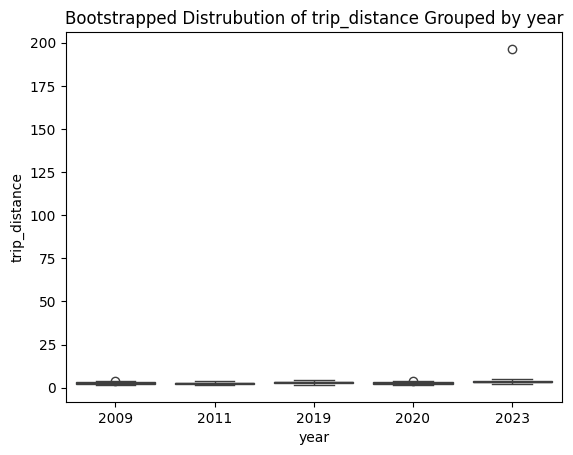

In [15]:
print(f"-----Comparing mean trip distance between different years-----")
anova_prep(all_years, boot_year, 'year','trip_distance')

In [ ]:
anova(boot_year,'year', 'trip_distance')

The p-value for this ANOVA is: 0.11806889256390841


Average trip_distance for 2009: 2.7632616000000003
Average trip_distance for 2011: 2.7025320000000006
Average trip_distance for 2019: 3.056714000000001
Average trip_distance for 2020: 2.7089160000000003
Average trip_distance for 2023: 3.486973737373738


Shapiro-Wilk test for 2009: p-value = 0.7505270838737488 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2011: p-value = 0.7694154977798462 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2019: p-value = 0.7943426966667175 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2020: p-value = 0.17768892645835876 - NORMAL DISTRIBUTION
Shapiro-Wilk test for 2023: p-value = 0.11277982592582703 - NORMAL DISTRIBUTION


Levene's test: p-value = 0.0070920753288886565 - NOT EQUAL VARIANCE


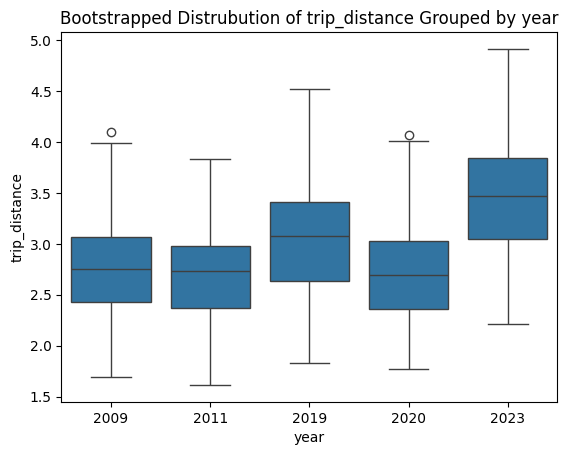

In [16]:
anova_prep(all_years, boot_year.loc[boot_year['trip_distance']<100], 'year','trip_distance')

In [ ]:
pg.welch_anova(dv='trip_distance', between='year', data = boot_year.loc[boot_year['trip_distance']<100])

,Source,ddof1,ddof2,F,p-unc,np2
0,year,4,246.092586,36.06891,1.027349e-23,0.250466


In [ ]:
pg.pairwise_gameshowell(data=boot_year.loc[boot_year['trip_distance']<100], dv='trip_distance',
                        between='year').round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,2009,2011,2.763,2.703,0.061,0.066,0.926,196.359,0.886,0.131
1,2009,2019,2.763,3.057,-0.293,0.076,-3.856,191.088,0.001,-0.543
2,2009,2020,2.763,2.709,0.054,0.068,0.794,198.000,0.932,0.112
3,2009,2023,2.763,3.487,-0.724,0.077,-9.376,188.069,0.000,-1.326
4,2011,2019,2.703,3.057,-0.354,0.073,-4.820,183.909,0.000,-0.679
5,2011,2020,2.703,2.709,-0.006,0.066,-0.097,196.382,1.000,-0.014
6,2011,2023,2.703,3.487,-0.784,0.075,-10.515,180.380,0.000,-1.487
7,2019,2020,3.057,2.709,0.348,0.076,4.571,191.043,0.000,0.644
8,2019,2023,3.057,3.487,-0.430,0.084,-5.121,196.838,0.000,-0.723
9,2020,2023,2.709,3.487,-0.778,0.077,-10.082,188.018,0.000,-1.426


Results for trip_distance~year has two different results. When keeping the outlier in year 2023, the assumption of normality passes for all years expect 2023, but equal variance passes. But, standard ANOVA shows no significant difference. However, when the outlier is removed, all groups are normal but equal variance is not satisfied anymore. We can still perform Welches ANOVA and Games Howell post hoc testing to work around the unequal variance. Using these methods, then there are differences between 2009 and 2019, 2009 and 2023, 2011 and 2019, 2011 and 2023, 2019 and 2020, 2019 and 2023 and 2020 and 2023.

-----Comparing mean tip percentage between different seasons-----
Average tip_percentage for Winter: 14.869510910238349
Average tip_percentage for Spring: 14.092382968882564
Average tip_percentage for Summer: 13.667428578580846
Average tip_percentage for Fall: 14.729505587084196


Shapiro-Wilk test for Winter: p-value = 1.1608616982366728e-16 - NOT NORMAL DISTRIBUTION
Shapiro-Wilk test for Spring: p-value = 0.0014926822623237967 - NOT NORMAL DISTRIBUTION
Shapiro-Wilk test for Summer: p-value = 0.42162081599235535 - NORMAL DISTRIBUTION
Shapiro-Wilk test for Fall: p-value = 0.36453989148139954 - NORMAL DISTRIBUTION


Levene's test: p-value = 0.06539379880796205 - EQUAL VARIANCE


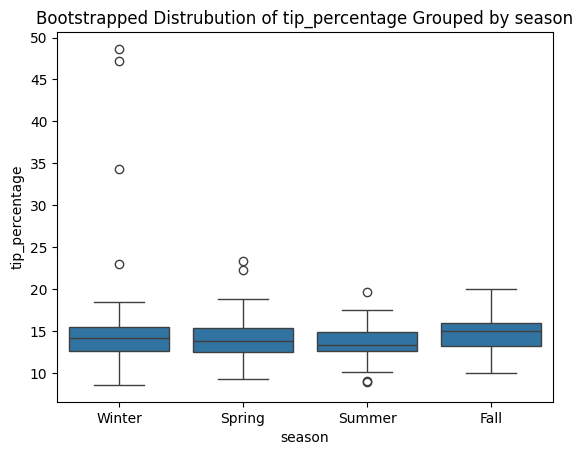

In [17]:
print(f"-----Comparing mean tip percentage between different seasons-----")
anova_prep(all_seasons, boot_season, 'season','tip_percentage')

In [ ]:
anova(boot_season,'season', 'tip_percentage')

The p-value for this ANOVA is: 0.04085001597541704
REJECT null hypothesis 

Post hoc testing: Tukey
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Fall Spring  -0.6371 0.5393 -1.8657 0.5915  False
  Fall Summer  -1.0621 0.1169 -2.2907 0.1665  False
  Fall Winter     0.14 0.9911 -1.0886 1.3686  False
Spring Summer   -0.425 0.8088 -1.6536 0.8037  False
Spring Winter   0.7771 0.3619 -0.4515 2.0058  False
Summer Winter   1.2021 0.0578 -0.0265 2.4307  False
---------------------------------------------------


Results for tip_percentage~season is no significant difference exists despite anova rejecting the null hypothesis.

-----Comparing mean trip distance between different seasons-----
Average trip_distance for Winter: 2.799995599999999
Average trip_distance for Spring: 2.907554
Average trip_distance for Summer: 3.0598800000000006
Average trip_distance for Fall: 2.945122


Shapiro-Wilk test for Winter: p-value = 0.5952171683311462 - NORMAL DISTRIBUTION
Shapiro-Wilk test for Spring: p-value = 0.4095456898212433 - NORMAL DISTRIBUTION
Shapiro-Wilk test for Summer: p-value = 0.10403987020254135 - NORMAL DISTRIBUTION
Shapiro-Wilk test for Fall: p-value = 0.2338414341211319 - NORMAL DISTRIBUTION


Levene's test: p-value = 0.8507725983875268 - EQUAL VARIANCE


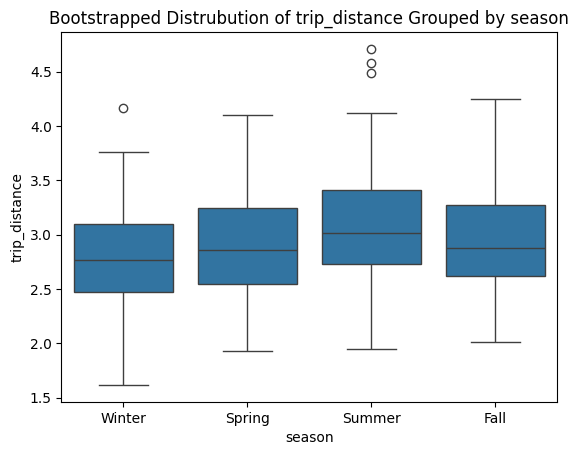

In [18]:
print(f"-----Comparing mean trip distance between different seasons-----")
anova_prep(all_seasons, boot_season, 'season','trip_distance')

In [ ]:
anova(boot_season,'season', 'trip_distance')

The p-value for this ANOVA is: 0.004028462170968851
REJECT null hypothesis 

Post hoc testing: Tukey
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring  -0.0376 0.9528 -0.2219  0.1468  False
  Fall Summer   0.1148 0.3764 -0.0696  0.2991  False
  Fall Winter  -0.1451 0.1783 -0.3295  0.0392  False
Spring Summer   0.1523 0.1448  -0.032  0.3367  False
Spring Winter  -0.1076 0.4353 -0.2919  0.0768  False
Summer Winter  -0.2599 0.0018 -0.4442 -0.0755   True
----------------------------------------------------


Results for trip_distance~season is difference between Summer and Winter

-----Comparing mean tip_percentage between passengers-----
Average tip_percentage for Single: 14.195197297311665
Average tip_percentage for Multiple: 12.460247803785194


Shapiro-Wilk test for Single: p-value = 0.11459696292877197 - NORMAL DISTRIBUTION
Shapiro-Wilk test for Multiple: p-value = 0.4726209342479706 - NORMAL DISTRIBUTION


Levene's test: p-value = 0.7458489433681876 - EQUAL VARIANCE


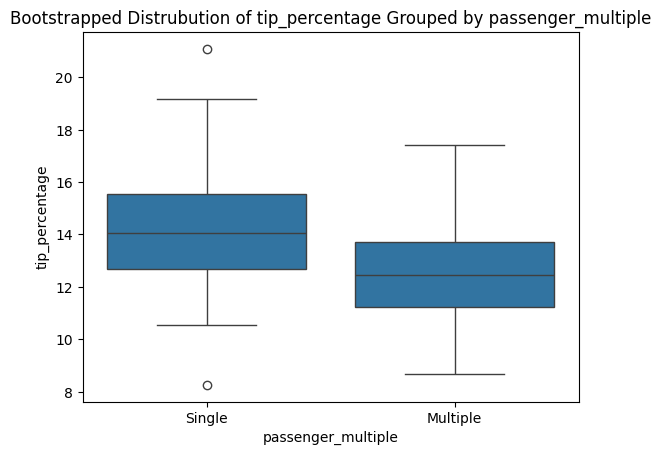

In [19]:
print(f"-----Comparing mean tip_percentage between passengers-----")
anova_prep(all_passengers, boot_passenger, 'passenger_multiple','tip_percentage')

In [ ]:
anova(boot_passenger,'passenger_multiple', 'tip_percentage')

The p-value for this ANOVA is: 3.505711628615281e-09
REJECT null hypothesis 

Post hoc testing: Tukey
Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1  group2 meandiff p-adj lower  upper  reject
---------------------------------------------------
Multiple Single   1.7349   0.0 1.1817 2.2882   True
---------------------------------------------------


Results for tip_percentage~passenger are that there is a difference in between single and multiple passenger.

-----Comparing mean trip_distance between passengers-----
Average trip_distance for Single: 2.9801839999999995
Average trip_distance for Multiple: 3.1545240000000003


Shapiro-Wilk test for Single: p-value = 0.0846630409359932 - NORMAL DISTRIBUTION
Shapiro-Wilk test for Multiple: p-value = 0.1822061985731125 - NORMAL DISTRIBUTION


Levene's test: p-value = 0.7259526509050797 - EQUAL VARIANCE


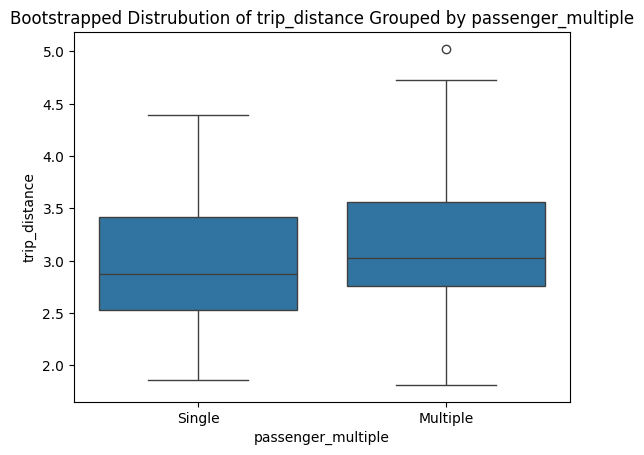

In [20]:
print(f"-----Comparing mean trip_distance between passengers-----")
anova_prep(all_passengers, boot_passenger, 'passenger_multiple','trip_distance')

In [ ]:
anova(boot_passenger,'passenger_multiple', 'trip_distance')

The p-value for this ANOVA is: 0.0450121486872123
REJECT null hypothesis 

Post hoc testing: Tukey
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------
Multiple Single  -0.1743 0.045 -0.3448 -0.0039   True
-----------------------------------------------------


The results for trip_distance~passenger is that there is a difference.